# Halpha Emitters S-PLUS

In [24]:
import numpy as np
import pandas as pd
import glob
from astropy.table import Table
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import hdbscan
import matplotlib.pyplot as plt
from itertools import combinations
import umap
import seaborn as sns; sns.set()
sns.set_theme(style="ticks")

In [25]:
# Open the CSV files
# Define the pattern to match CSV files
pattern = '../Ha-emitters/*PerField_wise.csv'

# Use glob to find all CSV files in the current directory
csv_files = glob.glob(pattern)

# Create an empty list to store DataFrames
dfs = []

In [26]:
# Loop through each CSV file and read it into a DataFrame
for file in csv_files:
    df = pd.read_csv(file)
    dfs.append(df)

In [27]:
# Concatenate all DataFrames into a single DataFrame
combined_df = pd.concat(dfs, ignore_index=True)
combined_df

,Field,ID,RA,DEC,X,Y,FWHM,FWHM_n,ISOarea,KRON_RADIUS,...,ccf,ex,var,qph,pmRA,e_pmRA,pmDE,e_pmDE,d2M,angDist
0,b'HYDRA-0013',b'iDR4_3_HYDRA-0013_0015750',154.559041,-24.256092,1246.0208,3215.7234,0.000261,0.800965,5.601852e-07,3.424156,...,0000,0,0nnn,ABUU,112.0,472.0,122.0,518.0,0.631,0.250428
1,b'HYDRA-0014',b'iDR4_3_HYDRA-0014_0033904',155.185702,-23.884339,6690.9863,5659.0760,0.000295,0.913361,6.768905e-07,3.690729,...,0000,0,0nnn,ACUU,1287.0,970.0,-152.0,1050.0,NaN,0.557740
2,b'HYDRA-0017',b'iDR4_3_HYDRA-0017_0004783',159.478848,-24.429063,8606.4780,2088.5144,0.000710,1.160942,7.702546e-07,4.263974,...,0000,0,1111,AAAA,43.0,326.0,239.0,201.0,0.394,0.186708
3,b'HYDRA-0017',b'iDR4_3_HYDRA-0017_0009083',160.646313,-24.254456,1643.3098,3228.3699,0.000589,0.963045,8.869599e-07,4.031962,...,0000,0,nnnn,BUUU,-714.0,1862.0,-473.0,2050.0,NaN,0.646986
4,b'HYDRA-0017',b'iDR4_3_HYDRA-0017_0031280',159.619490,-23.257862,7788.8887,9757.6770,0.000699,1.142811,1.143711e-06,4.497892,...,00P0,0,nnnn,BUUU,816.0,1931.0,-1869.0,2099.0,NaN,0.694878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,b'STRIPE82-0150',b'iDR4_3_STRIPE82-0150_0018595',344.672537,0.701005,3778.5828,5507.1250,0.000528,1.052337,4.084684e-06,3.541148,...,0000,0,00nn,AAUU,-112.0,202.0,-289.0,213.0,0.334,0.105043
3196,b'STRIPE82-0153',b'iDR4_3_STRIPE82-0153_0017701',347.188621,-0.903476,5863.5566,4168.6455,0.000307,0.958207,2.170718e-06,3.111347,...,0000,0,0nnn,ABUU,181.0,385.0,-126.0,399.0,0.225,0.184596
3197,b'STRIPE82-0156',b'iDR4_3_STRIPE82-0156_0022477',348.254420,0.658409,8164.3535,5228.3774,0.000325,0.965015,2.100695e-06,3.252210,...,0000,0,00nn,AAUU,-247.0,134.0,24.0,139.0,0.121,0.346572
3198,b'STRIPE82-0167',b'iDR4_3_STRIPE82-0167_0001018',357.468406,-1.349857,3517.2944,1246.5831,0.000358,1.081530,2.684221e-06,3.411331,...,0000,0,0nnn,ABUU,-52.0,742.0,-327.0,759.0,0.111,0.318382


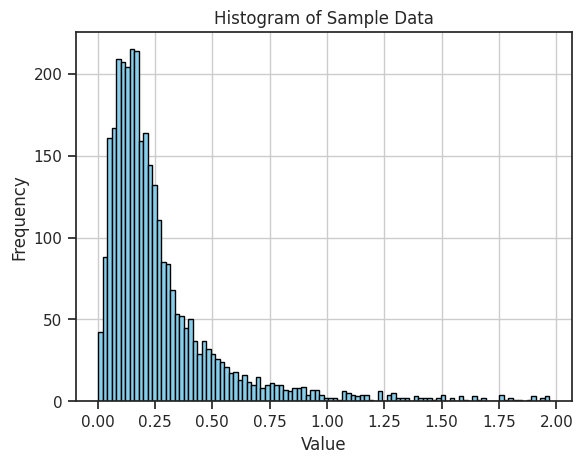

In [28]:
# See the distance of the SPLUS nad WISE source
# Plotting the histogram
plt.hist(combined_df["angDist"], bins=100, color='skyblue', edgecolor='black')  # You can adjust the number of bins as needed
plt.title('Histogram of Sample Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)  # Add grid lines for better readability
plt.show()



In [29]:
for columns in combined_df.columns:
    print(columns)

Field
ID
RA
DEC
X
Y
FWHM
FWHM_n
ISOarea
KRON_RADIUS
MU_MAX_INST
PETRO_RADIUS
SEX_FLAGS_DET
SEX_NUMBER_DET
CLASS_STAR
s2n_DET_PStotal
THETA
ELLIPTICITY
ELONGATION
FLUX_RADIUS_20
FLUX_RADIUS_50
FLUX_RADIUS_70
FLUX_RADIUS_90
s2n_r_PStotal
s2n_J0660_PStotal
s2n_i_PStotal
FWHM_r
FWHM_n_r
FWHM_J0660
FWHM_n_J0660
FWHM_i
FWHM_n_i
SEX_FLAGS_r
SEX_FLAGS_J0660
SEX_FLAGS_i
CLASS_STAR_r
CLASS_STAR_J0660
CLASS_STAR_i
r_PStotal
e_r_PStotal
g_PStotal
e_g_PStotal
i_PStotal
e_i_PStotal
u_PStotal
e_u_PStotal
z_PStotal
e_z_PStotal
J0378_PStotal
e_J0378_PStotal
J0395_PStotal
e_J0395_PStotal
J0410_PStotal
e_J0410_PStotal
J0430_PStotal
e_J0430_PStotal
J0515_PStotal
e_J0515_PStotal
J0660_PStotal
e_J0660_PStotal
J0861_PStotal
e_J0861_PStotal
r_psf
e_r_psf
g_psf
e_g_psf
i_psf
e_i_psf
u_psf
e_u_psf
z_psf
e_z_psf
J0378_psf
e_J0378_psf
J0395_psf
e_J0395_psf
J0410_psf
e_J0410_psf
J0430_psf
e_J0430_psf
J0515_psf
e_J0515_psf
J0660_psf
e_J0660_psf
J0861_psf
e_J0861_psf
AllWISE
RAJ2000
DEJ2000
eeMaj
eeMin
eePA
W1mag
W2

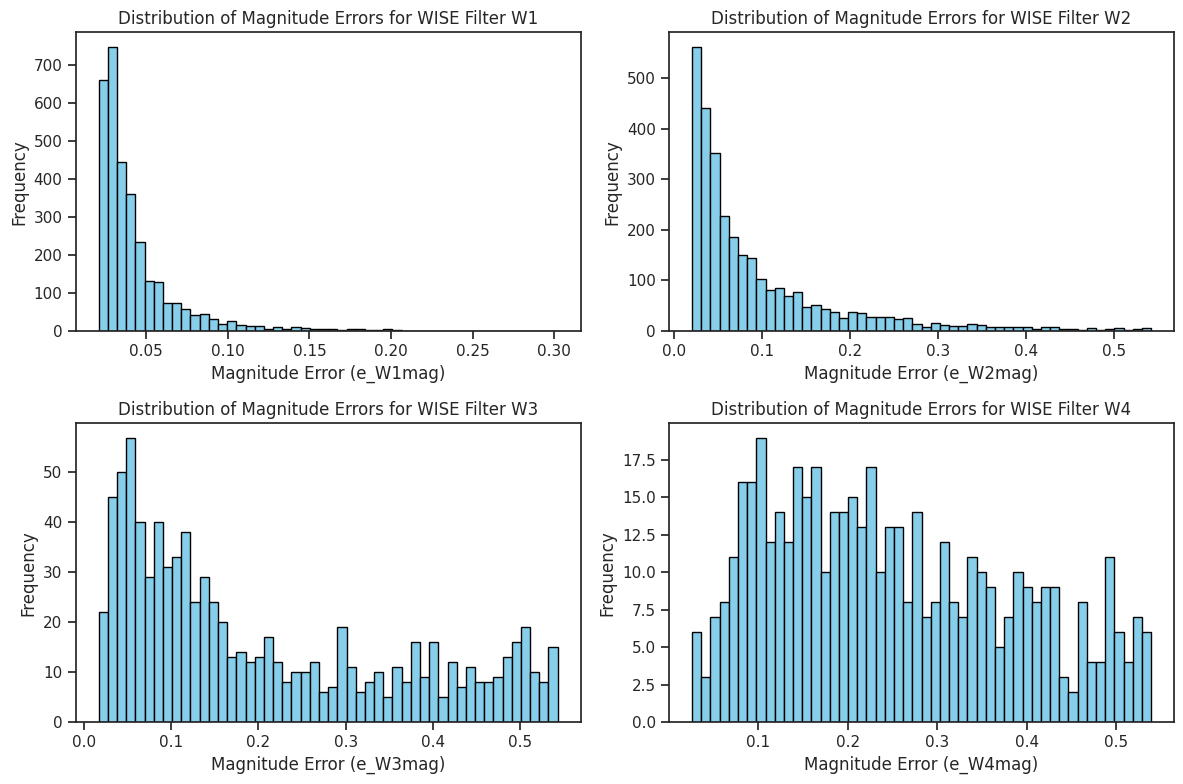

In [30]:
# Extract magnitude errors for WISE filters W1, W2, W3, W4
magnitude_errors_w1 = combined_df["e_W1mag"]
magnitude_errors_w2 = combined_df["e_W2mag"]
magnitude_errors_w3 = combined_df["e_W3mag"]
magnitude_errors_w4 = combined_df["e_W4mag"]

# Create subplots for each histogram
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Plot histogram for e_W1mag
axs[0, 0].hist(magnitude_errors_w1, bins=50, color='skyblue', edgecolor='black')
axs[0, 0].set_title('Distribution of Magnitude Errors for WISE Filter W1')
axs[0, 0].set_xlabel('Magnitude Error (e_W1mag)')
axs[0, 0].set_ylabel('Frequency')

# Plot histogram for e_W2mag
axs[0, 1].hist(magnitude_errors_w2, bins=50, color='skyblue', edgecolor='black')
axs[0, 1].set_title('Distribution of Magnitude Errors for WISE Filter W2')
axs[0, 1].set_xlabel('Magnitude Error (e_W2mag)')
axs[0, 1].set_ylabel('Frequency')

# Plot histogram for e_W3mag
axs[1, 0].hist(magnitude_errors_w3, bins=50, color='skyblue', edgecolor='black')
axs[1, 0].set_title('Distribution of Magnitude Errors for WISE Filter W3')
axs[1, 0].set_xlabel('Magnitude Error (e_W3mag)')
axs[1, 0].set_ylabel('Frequency')

# Plot histogram for e_W4mag
axs[1, 1].hist(magnitude_errors_w4, bins=50, color='skyblue', edgecolor='black')
axs[1, 1].set_title('Distribution of Magnitude Errors for WISE Filter W4')
axs[1, 1].set_xlabel('Magnitude Error (e_W4mag)')
axs[1, 1].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [31]:
# Cleaned error

m_err_splus = (combined_df["e_r_PStotal"] <= 0.2) & (combined_df["e_g_PStotal"] <= 0.2) & \
        (combined_df["e_i_PStotal"] <= 0.2) & (combined_df["e_u_PStotal"] <= 0.2) & \
        (combined_df["e_J0378_PStotal"] <= 0.2) & (combined_df["e_J0395_PStotal"] <= 0.2) & \
        (combined_df["e_J0410_PStotal"] <= 0.2) & (combined_df["e_J0430_PStotal"] <= 0.2) & \
        (combined_df["e_J0515_PStotal"] <= 0.2) & (combined_df["e_J0660_PStotal"] <= 0.2) & \
        (combined_df["e_J0861_PStotal"] <= 0.2) & (combined_df["e_z_PStotal"] <= 0.2) 

# Choose a threshold for the maximum allowed magnitude error
max_allowed_e_Wmag = 0.5  # Example threshold value

# Apply the threshold to filter the dataset

m_err_wise = (combined_df["e_W1mag"] <= max_allowed_e_Wmag) & (combined_df["e_W2mag"] <= max_allowed_e_Wmag) 
        

mask_total = (m_err_splus & m_err_wise)

In [32]:
df_cleanErr = combined_df[mask_total]
len(df_cleanErr)

1930

In [33]:
#Selecting columns
columns = ["r_PStotal",
"g_PStotal",
"i_PStotal",
"u_PStotal",
"z_PStotal",
"J0378_PStotal",
"J0395_PStotal",
"J0410_PStotal",
"J0430_PStotal",
"J0515_PStotal",
"J0660_PStotal",
"J0861_PStotal"]

In [34]:
df_mag = df_cleanErr[columns]
df_mag

,r_PStotal,g_PStotal,i_PStotal,u_PStotal,z_PStotal,J0378_PStotal,J0395_PStotal,J0410_PStotal,J0430_PStotal,J0515_PStotal,J0660_PStotal,J0861_PStotal
5,18.565330,18.934591,18.518396,19.290865,18.565490,18.957474,18.929663,18.850855,19.094093,19.050340,18.253527,18.561394
7,18.530138,18.905890,18.400469,19.014920,18.329327,18.776413,19.096212,18.962585,18.923103,18.941935,18.236492,18.337160
8,19.179417,19.535938,19.166569,19.595621,19.244514,19.505640,19.852362,19.594582,19.524601,19.546848,18.880930,19.309475
21,18.692910,18.994379,18.498499,20.197186,18.480791,19.676079,19.286104,18.917740,18.741314,18.500423,18.291922,18.191465
24,18.861261,19.178858,18.958980,19.610846,19.055391,19.319624,19.449575,19.297556,18.998985,18.999454,18.650702,19.172495
...,...,...,...,...,...,...,...,...,...,...,...,...
3192,16.803795,17.078941,16.696762,18.562077,16.714893,17.346140,16.763050,16.467522,16.418750,16.281357,16.466965,16.480146
3194,17.228241,17.834448,16.952242,19.910580,16.804752,19.566803,19.326944,18.518818,18.371190,17.724330,16.988983,16.686995
3195,16.454727,17.020280,16.226604,18.343782,16.140398,17.999746,18.000397,17.476097,17.347229,16.840440,15.717078,16.166605
3196,16.933338,17.387478,16.788050,18.523762,16.739445,18.187513,18.139862,17.701124,17.694130,17.217150,16.739262,16.780188


### Creating the colors 

In [35]:
# Generate all combinations of magnitude columns
color_index_pairs = list(combinations(df_mag, 2))
len(color_index_pairs)

66

In [36]:
def calculate_earnings(df, index_pairs):
    for index_pair in index_pairs:
        color_index_name = f"{index_pair[0]} - {index_pair[1]}"
        df.loc[:, color_index_name] = df[index_pair[0]] - df[index_pair[1]]
    return df

In [37]:
df_colors_mag = calculate_earnings(df_mag, color_index_pairs)

/tmp/ipykernel_1593667/262842159.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, color_index_name] = df[index_pair[0]] - df[index_pair[1]]
/tmp/ipykernel_1593667/262842159.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, color_index_name] = df[index_pair[0]] - df[index_pair[1]]
/tmp/ipykernel_1593667/262842159.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [38]:
df_colors_mag

,r_PStotal,g_PStotal,i_PStotal,u_PStotal,z_PStotal,J0378_PStotal,J0395_PStotal,J0410_PStotal,J0430_PStotal,J0515_PStotal,...,J0410_PStotal - J0430_PStotal,J0410_PStotal - J0515_PStotal,J0410_PStotal - J0660_PStotal,J0410_PStotal - J0861_PStotal,J0430_PStotal - J0515_PStotal,J0430_PStotal - J0660_PStotal,J0430_PStotal - J0861_PStotal,J0515_PStotal - J0660_PStotal,J0515_PStotal - J0861_PStotal,J0660_PStotal - J0861_PStotal
5,18.565330,18.934591,18.518396,19.290865,18.565490,18.957474,18.929663,18.850855,19.094093,19.050340,...,-0.243238,-0.199485,0.597328,0.289461,0.043753,0.840566,0.532699,0.796813,0.488946,-0.307867
7,18.530138,18.905890,18.400469,19.014920,18.329327,18.776413,19.096212,18.962585,18.923103,18.941935,...,0.039482,0.020650,0.726093,0.625425,-0.018832,0.686611,0.585943,0.705443,0.604775,-0.100668
8,19.179417,19.535938,19.166569,19.595621,19.244514,19.505640,19.852362,19.594582,19.524601,19.546848,...,0.069981,0.047734,0.713652,0.285107,-0.022247,0.643671,0.215126,0.665918,0.237373,-0.428545
21,18.692910,18.994379,18.498499,20.197186,18.480791,19.676079,19.286104,18.917740,18.741314,18.500423,...,0.176426,0.417317,0.625818,0.726275,0.240891,0.449392,0.549849,0.208501,0.308958,0.100457
24,18.861261,19.178858,18.958980,19.610846,19.055391,19.319624,19.449575,19.297556,18.998985,18.999454,...,0.298571,0.298102,0.646854,0.125061,-0.000469,0.348283,-0.173510,0.348752,-0.173041,-0.521793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3192,16.803795,17.078941,16.696762,18.562077,16.714893,17.346140,16.763050,16.467522,16.418750,16.281357,...,0.048772,0.186165,0.000557,-0.012624,0.137393,-0.048215,-0.061396,-0.185608,-0.198789,-0.013181
3194,17.228241,17.834448,16.952242,19.910580,16.804752,19.566803,19.326944,18.518818,18.371190,17.724330,...,0.147628,0.794488,1.529835,1.831823,0.646860,1.382207,1.684195,0.735347,1.037335,0.301988
3195,16.454727,17.020280,16.226604,18.343782,16.140398,17.999746,18.000397,17.476097,17.347229,16.840440,...,0.128868,0.635657,1.759019,1.309492,0.506789,1.630151,1.180624,1.123362,0.673835,-0.449527
3196,16.933338,17.387478,16.788050,18.523762,16.739445,18.187513,18.139862,17.701124,17.694130,17.217150,...,0.006994,0.483974,0.961862,0.920936,0.476980,0.954868,0.913942,0.477888,0.436962,-0.040926


In [39]:
# Drop magniytudes
df_colors = df_colors_mag.drop(columns=columns)

In [40]:
df_colors

,r_PStotal - g_PStotal,r_PStotal - i_PStotal,r_PStotal - u_PStotal,r_PStotal - z_PStotal,r_PStotal - J0378_PStotal,r_PStotal - J0395_PStotal,r_PStotal - J0410_PStotal,r_PStotal - J0430_PStotal,r_PStotal - J0515_PStotal,r_PStotal - J0660_PStotal,...,J0410_PStotal - J0430_PStotal,J0410_PStotal - J0515_PStotal,J0410_PStotal - J0660_PStotal,J0410_PStotal - J0861_PStotal,J0430_PStotal - J0515_PStotal,J0430_PStotal - J0660_PStotal,J0430_PStotal - J0861_PStotal,J0515_PStotal - J0660_PStotal,J0515_PStotal - J0861_PStotal,J0660_PStotal - J0861_PStotal
5,-0.369261,0.046934,-0.725535,-0.000160,-0.392144,-0.364333,-0.285525,-0.528763,-0.485010,0.311803,...,-0.243238,-0.199485,0.597328,0.289461,0.043753,0.840566,0.532699,0.796813,0.488946,-0.307867
7,-0.375752,0.129669,-0.484782,0.200811,-0.246275,-0.566074,-0.432447,-0.392965,-0.411797,0.293646,...,0.039482,0.020650,0.726093,0.625425,-0.018832,0.686611,0.585943,0.705443,0.604775,-0.100668
8,-0.356521,0.012848,-0.416204,-0.065097,-0.326223,-0.672945,-0.415165,-0.345184,-0.367431,0.298487,...,0.069981,0.047734,0.713652,0.285107,-0.022247,0.643671,0.215126,0.665918,0.237373,-0.428545
21,-0.301469,0.194411,-1.504276,0.212119,-0.983169,-0.593194,-0.224830,-0.048404,0.192487,0.400988,...,0.176426,0.417317,0.625818,0.726275,0.240891,0.449392,0.549849,0.208501,0.308958,0.100457
24,-0.317597,-0.097719,-0.749585,-0.194130,-0.458363,-0.588314,-0.436295,-0.137724,-0.138193,0.210559,...,0.298571,0.298102,0.646854,0.125061,-0.000469,0.348283,-0.173510,0.348752,-0.173041,-0.521793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3192,-0.275146,0.107033,-1.758282,0.088902,-0.542345,0.040745,0.336273,0.385045,0.522438,0.336830,...,0.048772,0.186165,0.000557,-0.012624,0.137393,-0.048215,-0.061396,-0.185608,-0.198789,-0.013181
3194,-0.606207,0.275999,-2.682339,0.423489,-2.338562,-2.098703,-1.290577,-1.142949,-0.496089,0.239258,...,0.147628,0.794488,1.529835,1.831823,0.646860,1.382207,1.684195,0.735347,1.037335,0.301988
3195,-0.565553,0.228123,-1.889055,0.314329,-1.545019,-1.545670,-1.021370,-0.892502,-0.385713,0.737649,...,0.128868,0.635657,1.759019,1.309492,0.506789,1.630151,1.180624,1.123362,0.673835,-0.449527
3196,-0.454140,0.145288,-1.590424,0.193893,-1.254175,-1.206524,-0.767786,-0.760792,-0.283812,0.194076,...,0.006994,0.483974,0.961862,0.920936,0.476980,0.954868,0.913942,0.477888,0.436962,-0.040926


***Making the color using some WISE filters***

In [41]:
# Calculate differences between W1 and each magnitude
for col in ["r_PStotal", "g_PStotal", "i_PStotal", "u_PStotal", "z_PStotal"]:
    df_colors[f'diff_W1_{col}'] = df_cleanErr["W1mag"] - df_cleanErr[col]

# Calculate differences between W2 and each magnitude
for col in ["r_PStotal", "g_PStotal", "i_PStotal", "u_PStotal", "z_PStotal"]:
    df_colors[f'diff_W2_{col}'] = df_cleanErr["W2mag"] - df_cleanErr[col]


In [42]:
# Calculate difference between W1 and W2
df_colors['diff_W1_W2'] = df_cleanErr['W1mag'] - df_cleanErr['W2mag']

In [44]:
for columns in df_colors.columns:
    print(columns)

r_PStotal - g_PStotal
r_PStotal - i_PStotal
r_PStotal - u_PStotal
r_PStotal - z_PStotal
r_PStotal - J0378_PStotal
r_PStotal - J0395_PStotal
r_PStotal - J0410_PStotal
r_PStotal - J0430_PStotal
r_PStotal - J0515_PStotal
r_PStotal - J0660_PStotal
r_PStotal - J0861_PStotal
g_PStotal - i_PStotal
g_PStotal - u_PStotal
g_PStotal - z_PStotal
g_PStotal - J0378_PStotal
g_PStotal - J0395_PStotal
g_PStotal - J0410_PStotal
g_PStotal - J0430_PStotal
g_PStotal - J0515_PStotal
g_PStotal - J0660_PStotal
g_PStotal - J0861_PStotal
i_PStotal - u_PStotal
i_PStotal - z_PStotal
i_PStotal - J0378_PStotal
i_PStotal - J0395_PStotal
i_PStotal - J0410_PStotal
i_PStotal - J0430_PStotal
i_PStotal - J0515_PStotal
i_PStotal - J0660_PStotal
i_PStotal - J0861_PStotal
u_PStotal - z_PStotal
u_PStotal - J0378_PStotal
u_PStotal - J0395_PStotal
u_PStotal - J0410_PStotal
u_PStotal - J0430_PStotal
u_PStotal - J0515_PStotal
u_PStotal - J0660_PStotal
u_PStotal - J0861_PStotal
z_PStotal - J0378_PStotal
z_PStotal - J0395_PStotal


# Reduction dimensionality

## UMAP 

Given that there are 66 variables, we use UMAP. I think UMAP is the best option because these variables are probably not linearly correlated. [UMAP](https://umap-learn.readthedocs.io/en/latest/) (Uniform Manifold Approximation and Projection) is a dimensionality reduction technique commonly used for visualizing high-dimensional data in lower-dimensional spaces. If you have 66 variables and suspect they are not linearly correlated, UMAP could be a suitable method for exploring the structure of your data in a lower-dimensional space while preserving non-linear relationships. However, the effectiveness of UMAP depends on various factors, including the nature of your data and the specific goals of your analysis. It's always a good idea to experiment with different techniques and evaluate their performance based on your data and objectives.

In [45]:
# Standarized the data
X_stand = StandardScaler().fit_transform(df_colors)

#### Try cross-validation 

To perform cross-validation for choosing the optimal number of components in UMAP.

In [46]:
# Split data into training and validation sets
X_train, X_val = train_test_split(X_stand, test_size=0.2, random_state=42)

In [47]:
# Define a range of number of components to try
num_components_range = [2, 3, 4, 5, 10, 20, 50]

best_num_components = None
best_silhouette_score = -1  # Initialize with a low value

In [48]:
# Loop over different numbers of components
for num_components in num_components_range:
    # Fit UMAP model
    reducer_ = umap.UMAP(n_neighbors=100, n_components=num_components, random_state=42)
    X_train_trans = reducer_.fit_transform(X_train)
    
    # Cluster the transformed data using KMeans
    kmeans = KMeans(n_clusters=num_components, random_state=42)
    labels = kmeans.fit_predict(X_train_trans)
    
    # Evaluate performance on validation set using Silhouette Score
    silhouette = silhouette_score(X_train_trans, labels, random_state=42)
    print(f"Number of components: {num_components}, Silhouette Score: {silhouette}")
    
    # Update best number of components and labels if necessary
    if silhouette > best_silhouette_score:
        best_silhouette_score = silhouette
        best_num_components = num_components
        best_labels = labels

Number of components: 2, Silhouette Score: 0.837996244430542
Number of components: 3, Silhouette Score: 0.6453626751899719
Number of components: 4, Silhouette Score: 0.5700827240943909
Number of components: 5, Silhouette Score: 0.5379304885864258
Number of components: 10, Silhouette Score: 0.46214762330055237
Number of components: 20, Silhouette Score: 0.4272061586380005
Number of components: 50, Silhouette Score: 0.3763355016708374


In [50]:
# After the loop, you'll have the best number of components and corresponding labels
print(f"Best number of components: {best_num_components}, Best Silhouette Score: {best_silhouette_score}")


Best number of components: 2, Best Silhouette Score: 0.837996244430542


#### Try UMAP

In [51]:
num_components = 2
reducer = umap.UMAP(n_neighbors=100, # default 15, The size of local neighborhood (in terms of number of neighboring sample points) used for manifold approximation.
                    n_components=num_components,  # min_samples=15, min_cluster_size=60
                    random_state=42)
X_trans = reducer.fit_transform(X_stand)

Visualize the cumulative explained variance ratio:

In [52]:
# Calculate the variance of the original data points in the reduced space
original_variance = np.var(X_trans, axis=0)

# Calculate the explained variance ratio
explained_variance_ratio = original_variance / np.sum(original_variance)

# Calculate the cumulative explained variance ratio
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

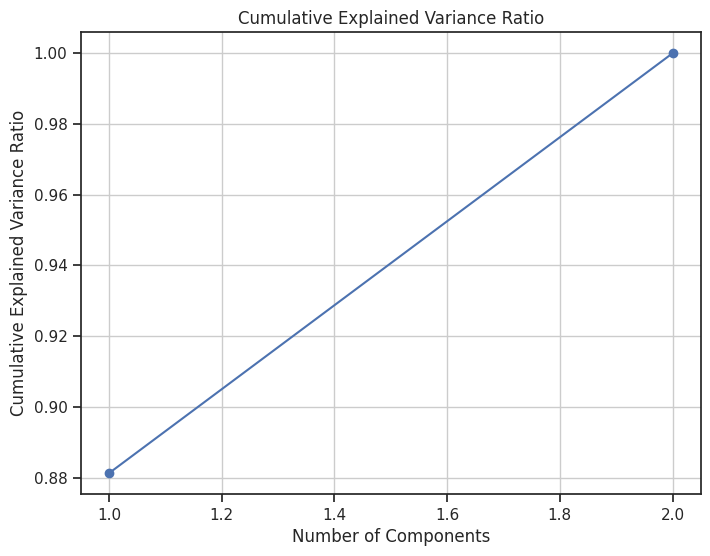

In [53]:
# Plot the cumulative explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(cumulative_explained_variance_ratio) + 1), cumulative_explained_variance_ratio, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

In [54]:
#umap_df = pd.DataFrame(X_trans, columns = ["PC1", "PC2", "PC3"])
# Create a DataFrame for PCA results
umap_columns = [f'PC{i}' for i in range(1, num_components + 1)]
umap_df = pd.DataFrame(data=X_trans, columns=umap_columns)
umap_df

,PC1,PC2
0,-3.462312,11.451462
1,-3.557892,10.870927
2,-3.511737,12.145880
3,9.163614,10.330036
4,-3.082697,12.308144
...,...,...
1925,8.829683,10.545156
1926,14.321586,5.590698
1927,14.023168,9.474492
1928,11.432090,10.434398


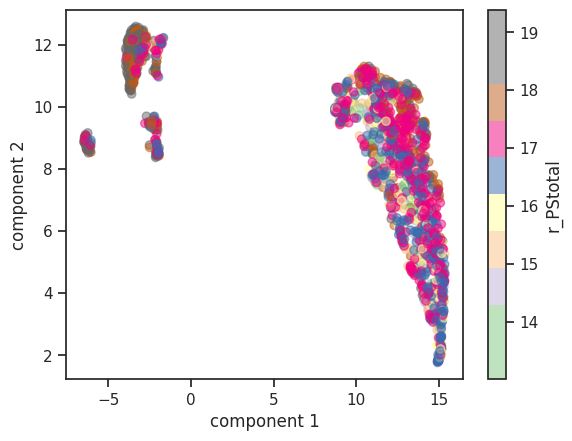

In [55]:
# Assuming umap_df is your DataFrame containing UMAP components and g_PStotal column
plt.scatter(umap_df["PC1"], umap_df["PC2"],
            c=df_cleanErr["r_PStotal"],  # Set color based on the values of "g_PStotal"
            alpha=0.5,
            cmap=plt.cm.get_cmap('Accent', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar(label='r_PStotal')  # Set the label of the color bar to 'g_PStotal'
plt.show()

## HDBSCAN 

#### Find the best parameters 

To find the best min_samples and min_cluster_size parameters for HDBSCAN, you typically perform a grid search over a range of values and evaluate the clustering performance using a metric such as silhouette score or another relevant metric.

Here's a general approach you can follow:

    Define a grid of parameters to search over for min_samples and min_cluster_size.
    For each combination of parameters:
        Fit HDBSCAN to your data.
        Evaluate the clustering performance using a metric such as silhouette score.
    Select the parameters that result in the highest clustering performance according to your chosen metric.

Here's how you can perform this grid search:

In [56]:

# Define the range of values for min_samples and min_cluster_size
min_samples_range = [5, 10, 15, 20, 25, 30, 35]  # Adjust as needed
min_cluster_size_range = [40, 50, 60, 80, 100, 120, 150]  # Adjust as needed

In [57]:
best_score = -1
best_params = {}


In [58]:
for min_samples in min_samples_range:
    for min_cluster_size in min_cluster_size_range:
        # Fit HDBSCAN with the current parameters
        clusterer_ = hdbscan.HDBSCAN(min_samples=min_samples, min_cluster_size=min_cluster_size)
        labels = clusterer_.fit_predict(X_trans)  # X is your data
        
        # Evaluate clustering performance using silhouette score
        silhouette_ = silhouette_score(X_trans, labels)
        
        # Check if current parameters result in a better silhouette score
        if silhouette_ > best_score:
            best_score = silhouette_
            best_params['min_samples'] = min_samples
            best_params['min_cluster_size'] = min_cluster_size

In [59]:
print("Best parameters:", best_params)
print("Best silhouette score:", best_score)

Best parameters: {'min_samples': 5, 'min_cluster_size': 150}
Best silhouette score: 0.7986534


### Applying HDBSCAN 

I foun that the best configurations of parameteres are 'min_samples': 5 and 'min_cluster_size': 150. We try then: 
But first try this min_samples=15, min_cluster_size=60

In [60]:
clusterer = hdbscan.HDBSCAN(min_samples=5, min_cluster_size=150, prediction_data=True, gen_min_span_tree=True)
#clusterer = hdbscan.HDBSCAN(min_cluster_size=40, min_samples=1, gen_min_span_tree=True)


In [61]:

clusterer.fit(X_trans)
labels = clusterer.labels_

In [62]:
clusterer.metric

'euclidean'

In [63]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_cluster0 = list(labels).count(0)
n_cluster1 = list(labels).count(1)
n_cluster2 = list(labels).count(2)
n_cluster3 = list(labels).count(3)
n_noise_ = list(labels).count(-1)


In [64]:
# Print parameters
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of cluster points 0: %d' % n_cluster0)
print('Estimated number of cluster points 1: %d' % n_cluster1)
print('Estimated number of cluster points 2: %d' % n_cluster2)
print('Estimated number of cluster points 3: %d' % n_cluster3)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 2
Estimated number of cluster points 0: 490
Estimated number of cluster points 1: 1440
Estimated number of cluster points 2: 0
Estimated number of cluster points 3: 0
Estimated number of noise points: 0


<AxesSubplot: >

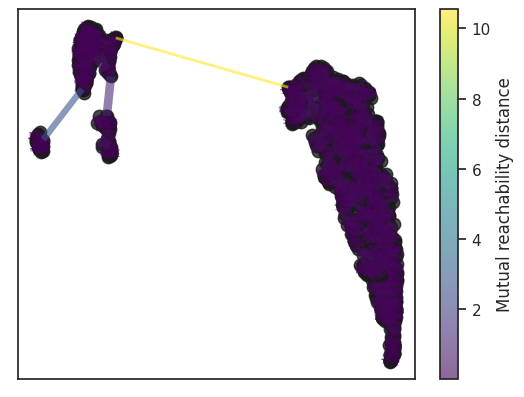

In [65]:
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.6,
                                      node_size=80,
                                      edge_linewidth=2)


### Build the cluster hierarchy 

<AxesSubplot: ylabel='distance'>

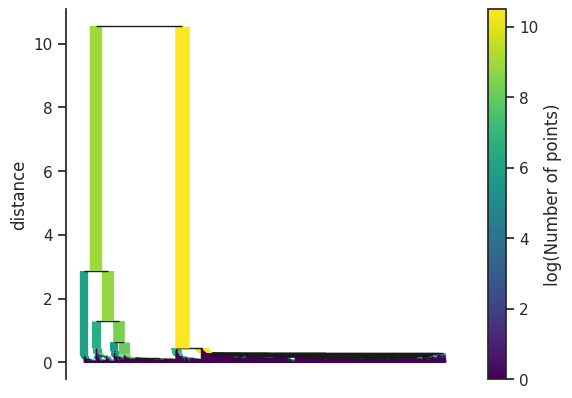

In [66]:
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

### Extract the clusters

<AxesSubplot: ylabel='$\\lambda$ value'>

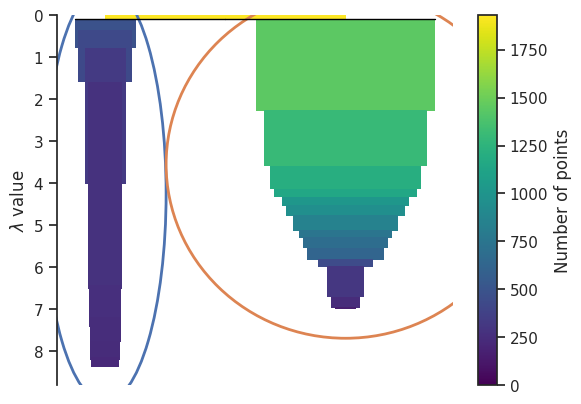

In [67]:
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

Plting the components

/home/luisangel/luis-env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot: xlabel='PC1', ylabel='PC2'>

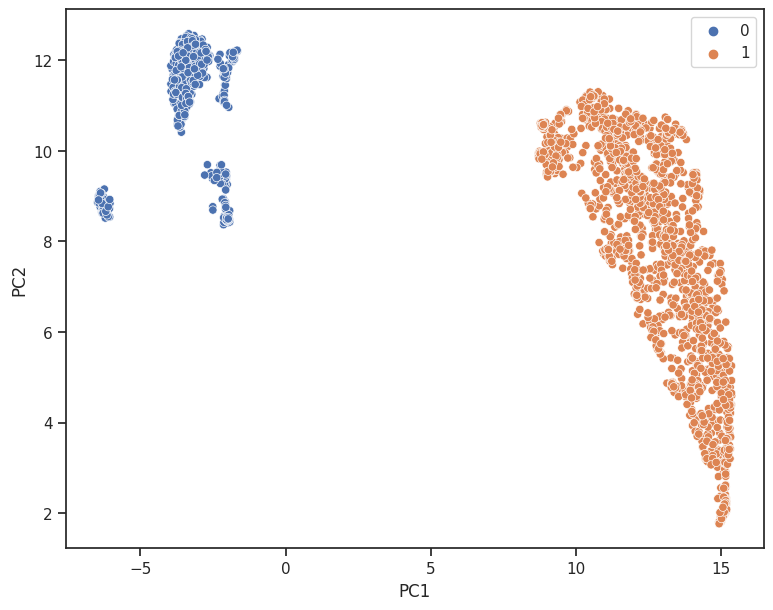

In [68]:
plt.figure(figsize=(9,7))
sns.scatterplot(umap_df["PC1"], umap_df["PC2"], 
                hue=labels,
                )

Create the tables for each clase

In [39]:
df_cleanErr["Label"] = labels

/tmp/ipykernel_1591339/341984377.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleanErr["Label"] = labels


In [40]:
df_cleanErr

,Field,ID,RA,DEC,X,Y,FWHM,FWHM_n,ISOarea,KRON_RADIUS,...,e_J0410_psf,J0430_psf,e_J0430_psf,J0515_psf,e_J0515_psf,J0660_psf,e_J0660_psf,J0861_psf,e_J0861_psf,Label
0,b'HYDRA-0011',b'iDR4_3_HYDRA-0011_0001534',151.228065,-24.565881,2768.8430,1194.1807,0.000344,1.109519,7.119020e-06,2.708475,...,0.045,16.612030,0.040,15.790031,0.034,14.886657,0.028,14.564144,0.031,0
1,b'HYDRA-0021',b'iDR4_3_HYDRA-0021_0019499',151.820602,-25.619486,1653.6090,3400.8994,0.000307,1.081890,2.490490e-05,2.232373,...,0.016,13.265827,0.014,13.113828,0.012,13.033432,0.020,13.019970,0.019,0
2,b'HYDRA-0023',b'iDR4_3_HYDRA-0023_0021195',154.612704,-25.530006,3569.1528,3993.6829,0.000317,0.949352,1.283758e-05,2.532320,...,0.011,15.336150,0.009,14.717150,0.007,14.074205,0.016,NaN,NaN,0
3,b'HYDRA-0026',b'iDR4_3_HYDRA-0026_0046098',158.459389,-24.620632,8485.7730,9943.1000,0.000367,1.218677,7.749229e-06,2.742691,...,NaN,NaN,NaN,15.129318,0.027,NaN,NaN,NaN,NaN,0
4,b'HYDRA-0031',b'iDR4_3_HYDRA-0031_0032774',150.917736,-26.667847,9368.1560,5633.4710,0.000384,1.078957,7.585842e-06,2.917582,...,0.022,15.775820,0.015,15.204820,0.023,15.071949,0.020,15.141534,0.030,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3646,b'STRIPE82-0132',b'iDR4_3_STRIPE82-0132_0011586',331.997487,0.289613,3249.1740,2814.3223,0.000363,1.000263,1.213735e-06,4.081015,...,0.052,18.992230,0.054,19.004229,0.046,18.468687,0.028,18.563194,0.056,2
3650,b'STRIPE82-0142',b'iDR4_3_STRIPE82-0142_0014029',339.139727,0.448016,2885.1482,3851.2144,0.000379,1.013615,6.535494e-07,4.638296,...,0.128,19.544977,0.113,19.558977,0.101,18.884567,0.041,19.348486,0.141,3
3654,b'STRIPE82-0147',b'iDR4_3_STRIPE82-0147_0003349',343.495206,-1.289140,2208.1868,1643.8495,0.000305,0.945969,7.469136e-07,3.516137,...,0.097,19.491743,0.080,19.246742,0.066,18.590178,0.029,18.753134,0.091,3
3656,b'STRIPE82-0151',b'iDR4_3_STRIPE82-0151_0033785',346.434130,-0.425545,1524.9784,7296.7880,0.000348,0.984726,6.535494e-07,3.597043,...,0.119,19.924389,0.120,19.170390,0.065,18.583260,0.032,18.903078,0.097,0


**Preliminary conlusions**\\
Wiht the parameters recomended by the Silhouette HDBSCAM fin two group, on which one corresponds to the EB. BUt using (min_samples=15, min_cluster_size=60 HDBCAM find four group one coressponds to to the EB, aother to CV and QSOS and AGN, and the other two to QSOS each one corresnp a specific redshift.

In [41]:
# Group the data based on the "Label" column
grouped_data = df_cleanErr.groupby("Label")

In [42]:
# Define the directory where you want to save the CSV files
directory = '../Class_allfilter_wise/'

In [49]:
# Iterate over each group
for label, group_df in grouped_data:
    if label == -1:  # Noise points
        filename = f'Halpha_emitter_wise_noise.csv'
    else:
        filename = f'Halpha_emitter_wise_group{label}.csv'
    group_df.to_csv(directory + filename, index=False)

NameError: name 'grouped_data' is not defined